# Configuring TF Object Detection API on AML GPU compute instance

This notebook shows how to train a deeplearning model to detect objects within an image using tensorflow object detection api. 

## Install tensorwflow-gpu

In [1]:
# install the following libs. 
!pip install -U --pre tensorflow-gpu=="2.*"
!pip install tf_slim
!pip install pycocotools

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import os
import pathlib
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [2]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [1]:
# if you are using AMLS GPU compute instance, after a successful installation of above you should see your gpu device info and version of tf (e.g. 2.* running on your compute instance):
import tensorflow as tf
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
!python3 -c 'import tensorflow as tf; print(tf.__version__)'

2021-01-05 20:02:48.603708: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2.3.1


## Install tensowflow object detection api

In [4]:
! git clone https://github.com/tensorflow/models.git
! git clone https://github.com/cocodataset/cocoapi.git    

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cd ../../cocoapi/PythonAPI
make
cp -r pycocotools ../../models/research/

## Annotate Images

Use a tool such as https://github.com/tzutalin/labelImg#usage) to annotate images inside ./images directory

## Create Label Map

create a labelmap inside the annotations folder

## Create TensorFlow Records

In [20]:
# Create train data:
!python generate_tfrecord.py -x images/train -l annotations/labelmap.pbtxt -o annotations/train.record

# Create test data:
!python generate_tfrecord.py -x images/test -l images/labelmap.pbtxt -o images/test.record


# Configuring a Training Job
## Download and configure a pre-trained model for training on new images

In [15]:
# download a pre-trained model based on your need from 
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
!curl http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz --output faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz

In [16]:
%%bash
tar -xvzf faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz
cp ./faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8/pipeline.config ./training_pipeline
#make necessary changes in pipeline.config (e.g. number of classes, path to the pre-trained model, labelmap.pbtxt, etc)

In [ ]:
# Train your model 
!python model_main_tf2.py --model_dir=./training_pipeline/ --pipeline_config_path=./training_pipeline/pipeline.config

In [ ]:
#Export your Trained Model
!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path ./training_pipeline/pipeline.config --trained_checkpoint_dir ./training_pipeline/ --output_directory ./exported-model

## object/segment detection using the trained model

In [3]:
def load_model():
    model_dir = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/nvidia-teslak80/code/tf-object-detection-api/models/research/object_detection/colab_tutorials/exported_model_2/saved_model"
    model = tf.saved_model.load(str(model_dir))
    return model

In [4]:
PATH_TO_LABELS  = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nvidia-teslak80/code/tf-object-detection-api/models/research/object_detection/colab_tutorials/annotations/labelmap.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [5]:
detection_model = load_model()

In [6]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [7]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

In [11]:
# print(detection_model.signatures['serving_default'].inputs)

In [10]:
# detection_model.signatures['serving_default'].output_dtypes

In [9]:
# detection_model.signatures['serving_default'].output_shapes

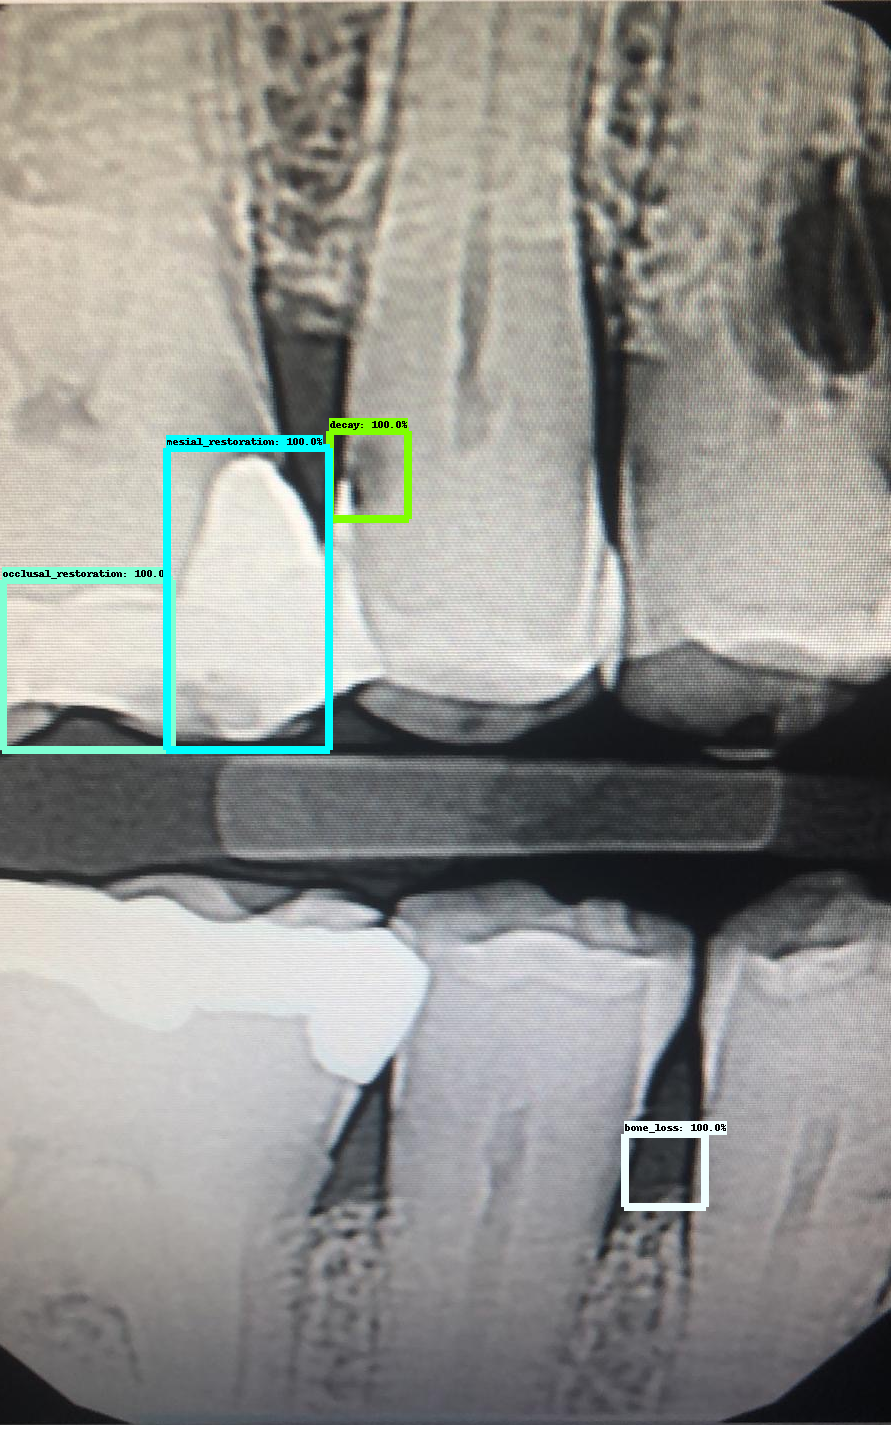

In [8]:
show_inference(detection_model, '1.png')